# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

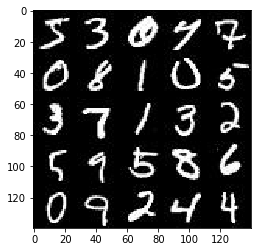

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

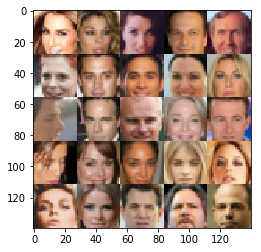

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='real_inputs')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return real_inputs, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):         
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * bn1, bn1)
        
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
       
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        do3 = tf.nn.dropout(x3, 0.5)
        bn3 = tf.layers.batch_normalization(do3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        

        
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.01
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*1024)

        x1 = tf.reshape(x1, (-1, 7, 7, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, 0.5)
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, 0.5)
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, 0.5)

        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
       
        out = tf.tanh(logits) 
   
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    images_count, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                batch_images *= 2                  
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % 10 == 0:                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6256... Generator Loss: 1.7317
Epoch 1/2... Discriminator Loss: 0.6825... Generator Loss: 2.0424
Epoch 1/2... Discriminator Loss: 0.6739... Generator Loss: 2.4463
Epoch 1/2... Discriminator Loss: 1.3284... Generator Loss: 0.7634
Epoch 1/2... Discriminator Loss: 0.6273... Generator Loss: 2.7808
Epoch 1/2... Discriminator Loss: 0.6935... Generator Loss: 1.8447
Epoch 1/2... Discriminator Loss: 1.3864... Generator Loss: 0.7131
Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 1.6979
Epoch 1/2... Discriminator Loss: 0.9085... Generator Loss: 1.6166
Epoch 1/2... Discriminator Loss: 1.0360... Generator Loss: 1.2747


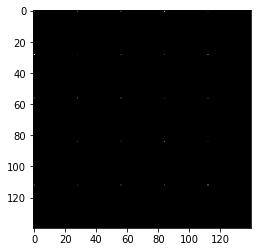

Epoch 1/2... Discriminator Loss: 1.3610... Generator Loss: 0.8733
Epoch 1/2... Discriminator Loss: 1.2065... Generator Loss: 1.6992
Epoch 1/2... Discriminator Loss: 1.1129... Generator Loss: 1.0974
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 0.8133
Epoch 1/2... Discriminator Loss: 0.9794... Generator Loss: 2.9071
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 0.6762
Epoch 1/2... Discriminator Loss: 0.7867... Generator Loss: 1.2392
Epoch 1/2... Discriminator Loss: 0.9412... Generator Loss: 1.2229
Epoch 1/2... Discriminator Loss: 0.9344... Generator Loss: 1.1802
Epoch 1/2... Discriminator Loss: 1.2323... Generator Loss: 1.0519


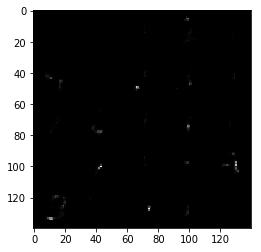

Epoch 1/2... Discriminator Loss: 1.2556... Generator Loss: 0.7664
Epoch 1/2... Discriminator Loss: 1.1698... Generator Loss: 1.0305
Epoch 1/2... Discriminator Loss: 1.3265... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 1.2291
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 1.4098
Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 1.2455
Epoch 1/2... Discriminator Loss: 1.0490... Generator Loss: 1.7159
Epoch 1/2... Discriminator Loss: 1.0572... Generator Loss: 1.1225
Epoch 1/2... Discriminator Loss: 1.5185... Generator Loss: 0.5255
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 1.7723


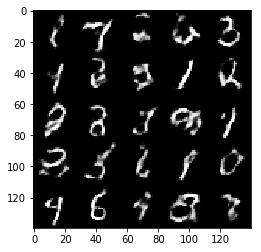

Epoch 1/2... Discriminator Loss: 1.3176... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 1.5818
Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 0.9994
Epoch 1/2... Discriminator Loss: 1.2911... Generator Loss: 1.1342
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 2.4205
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 0.7768
Epoch 1/2... Discriminator Loss: 1.0010... Generator Loss: 2.1327
Epoch 1/2... Discriminator Loss: 0.8720... Generator Loss: 1.6440
Epoch 1/2... Discriminator Loss: 1.1026... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 1.0956... Generator Loss: 1.8242


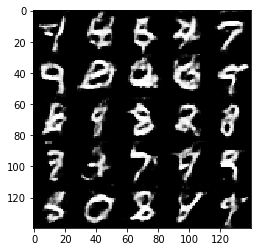

Epoch 1/2... Discriminator Loss: 1.1608... Generator Loss: 2.1887
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 1.7158
Epoch 1/2... Discriminator Loss: 1.3105... Generator Loss: 1.9759
Epoch 1/2... Discriminator Loss: 0.9519... Generator Loss: 1.3885
Epoch 1/2... Discriminator Loss: 1.0141... Generator Loss: 1.1393
Epoch 1/2... Discriminator Loss: 1.1570... Generator Loss: 1.7767
Epoch 2/2... Discriminator Loss: 0.9946... Generator Loss: 1.1995
Epoch 2/2... Discriminator Loss: 0.9592... Generator Loss: 1.0685
Epoch 2/2... Discriminator Loss: 1.1256... Generator Loss: 0.8898
Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.7861


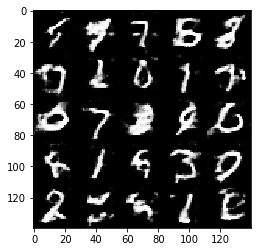

Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 2.0899
Epoch 2/2... Discriminator Loss: 1.4048... Generator Loss: 0.5524
Epoch 2/2... Discriminator Loss: 0.9630... Generator Loss: 1.5975
Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 1.2614
Epoch 2/2... Discriminator Loss: 2.7495... Generator Loss: 3.0460
Epoch 2/2... Discriminator Loss: 1.0294... Generator Loss: 1.2972
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.3040
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 2.3195
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.7365
Epoch 2/2... Discriminator Loss: 1.5949... Generator Loss: 0.5134


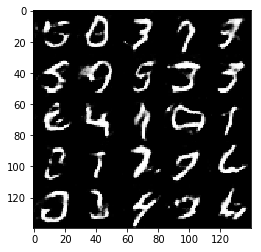

Epoch 2/2... Discriminator Loss: 0.8129... Generator Loss: 1.6130
Epoch 2/2... Discriminator Loss: 0.8601... Generator Loss: 1.4299
Epoch 2/2... Discriminator Loss: 0.9543... Generator Loss: 1.8735
Epoch 2/2... Discriminator Loss: 1.0901... Generator Loss: 1.2036
Epoch 2/2... Discriminator Loss: 0.8983... Generator Loss: 1.2033
Epoch 2/2... Discriminator Loss: 1.4306... Generator Loss: 0.6086
Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 1.4936
Epoch 2/2... Discriminator Loss: 1.0925... Generator Loss: 0.9950
Epoch 2/2... Discriminator Loss: 0.9259... Generator Loss: 2.3120
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 1.3941


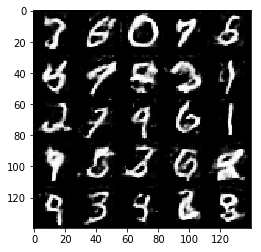

Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.9159
Epoch 2/2... Discriminator Loss: 1.0814... Generator Loss: 2.1611
Epoch 2/2... Discriminator Loss: 1.0856... Generator Loss: 2.4970
Epoch 2/2... Discriminator Loss: 0.7234... Generator Loss: 1.8801
Epoch 2/2... Discriminator Loss: 0.9456... Generator Loss: 1.6118
Epoch 2/2... Discriminator Loss: 0.8305... Generator Loss: 1.1326
Epoch 2/2... Discriminator Loss: 1.6177... Generator Loss: 0.5350
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 2.2403
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 0.9370
Epoch 2/2... Discriminator Loss: 0.8584... Generator Loss: 1.5305


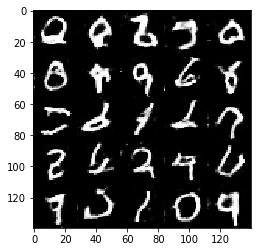

Epoch 2/2... Discriminator Loss: 1.0404... Generator Loss: 1.0148
Epoch 2/2... Discriminator Loss: 1.1748... Generator Loss: 2.8091
Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.6605
Epoch 2/2... Discriminator Loss: 0.8848... Generator Loss: 1.8365
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 0.8998
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 0.9496
Epoch 2/2... Discriminator Loss: 0.8009... Generator Loss: 1.4856
Epoch 2/2... Discriminator Loss: 1.0867... Generator Loss: 3.1444
Epoch 2/2... Discriminator Loss: 0.8657... Generator Loss: 1.3154
Epoch 2/2... Discriminator Loss: 1.3442... Generator Loss: 0.6164


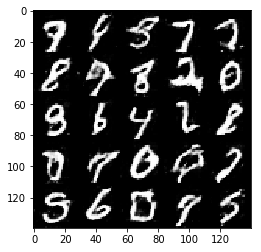

Epoch 2/2... Discriminator Loss: 1.0516... Generator Loss: 1.2058
Epoch 2/2... Discriminator Loss: 0.9079... Generator Loss: 1.2949
Epoch 2/2... Discriminator Loss: 0.8283... Generator Loss: 1.4905


In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/3... Discriminator Loss: 0.4362... Generator Loss: 3.9705
Epoch 1/3... Discriminator Loss: 0.4978... Generator Loss: 4.0577
Epoch 1/3... Discriminator Loss: 0.6153... Generator Loss: 2.1941
Epoch 1/3... Discriminator Loss: 0.6991... Generator Loss: 2.6961
Epoch 1/3... Discriminator Loss: 0.5336... Generator Loss: 2.5962
Epoch 1/3... Discriminator Loss: 1.0242... Generator Loss: 0.9342
Epoch 1/3... Discriminator Loss: 0.4737... Generator Loss: 4.7350
Epoch 1/3... Discriminator Loss: 0.3650... Generator Loss: 4.7592
Epoch 1/3... Discriminator Loss: 0.3807... Generator Loss: 3.8142
Epoch 1/3... Discriminator Loss: 1.1129... Generator Loss: 3.9887


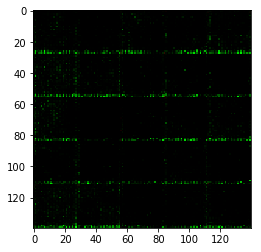

Epoch 1/3... Discriminator Loss: 0.4433... Generator Loss: 3.4740
Epoch 1/3... Discriminator Loss: 0.4022... Generator Loss: 4.5335
Epoch 1/3... Discriminator Loss: 0.3685... Generator Loss: 4.4616
Epoch 1/3... Discriminator Loss: 2.4194... Generator Loss: 0.1727
Epoch 1/3... Discriminator Loss: 0.9353... Generator Loss: 1.6599
Epoch 1/3... Discriminator Loss: 1.2719... Generator Loss: 3.1339
Epoch 1/3... Discriminator Loss: 0.7877... Generator Loss: 1.5328
Epoch 1/3... Discriminator Loss: 1.3189... Generator Loss: 0.6368
Epoch 1/3... Discriminator Loss: 2.6384... Generator Loss: 0.1419
Epoch 1/3... Discriminator Loss: 1.3085... Generator Loss: 1.1104


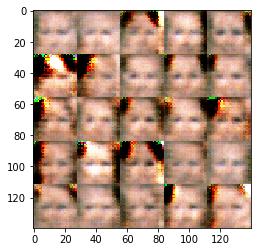

Epoch 1/3... Discriminator Loss: 1.1777... Generator Loss: 1.1354
Epoch 1/3... Discriminator Loss: 1.0410... Generator Loss: 1.0948
Epoch 1/3... Discriminator Loss: 1.4470... Generator Loss: 2.2556
Epoch 1/3... Discriminator Loss: 1.3380... Generator Loss: 0.6395
Epoch 1/3... Discriminator Loss: 1.5599... Generator Loss: 0.4870
Epoch 1/3... Discriminator Loss: 0.9544... Generator Loss: 1.3109
Epoch 1/3... Discriminator Loss: 1.4416... Generator Loss: 0.5598
Epoch 1/3... Discriminator Loss: 0.9403... Generator Loss: 1.3039
Epoch 1/3... Discriminator Loss: 1.8256... Generator Loss: 0.2970
Epoch 1/3... Discriminator Loss: 1.1701... Generator Loss: 2.0873


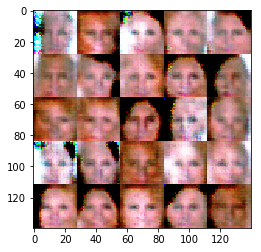

Epoch 1/3... Discriminator Loss: 0.9450... Generator Loss: 1.3989
Epoch 1/3... Discriminator Loss: 3.8881... Generator Loss: 6.5545
Epoch 1/3... Discriminator Loss: 1.4606... Generator Loss: 0.5732
Epoch 1/3... Discriminator Loss: 1.5182... Generator Loss: 0.7023
Epoch 1/3... Discriminator Loss: 1.1452... Generator Loss: 1.2019
Epoch 1/3... Discriminator Loss: 1.1069... Generator Loss: 0.8848
Epoch 1/3... Discriminator Loss: 1.1201... Generator Loss: 1.0324
Epoch 1/3... Discriminator Loss: 1.8337... Generator Loss: 2.4075
Epoch 1/3... Discriminator Loss: 1.1065... Generator Loss: 0.9048
Epoch 1/3... Discriminator Loss: 1.4142... Generator Loss: 0.9934


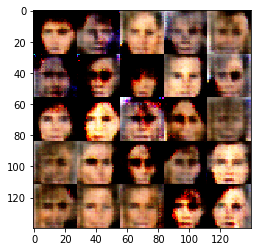

Epoch 1/3... Discriminator Loss: 1.1608... Generator Loss: 0.9196
Epoch 1/3... Discriminator Loss: 1.2393... Generator Loss: 0.8212
Epoch 1/3... Discriminator Loss: 1.2861... Generator Loss: 0.9420
Epoch 1/3... Discriminator Loss: 1.2725... Generator Loss: 0.7018
Epoch 1/3... Discriminator Loss: 1.1262... Generator Loss: 1.1446
Epoch 1/3... Discriminator Loss: 1.4772... Generator Loss: 0.5644
Epoch 1/3... Discriminator Loss: 2.1819... Generator Loss: 0.2377
Epoch 1/3... Discriminator Loss: 1.2311... Generator Loss: 0.8909
Epoch 1/3... Discriminator Loss: 1.1587... Generator Loss: 0.9368
Epoch 1/3... Discriminator Loss: 1.2183... Generator Loss: 0.9605


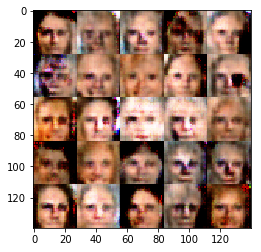

Epoch 1/3... Discriminator Loss: 1.3234... Generator Loss: 0.7621
Epoch 1/3... Discriminator Loss: 1.2318... Generator Loss: 1.3655
Epoch 1/3... Discriminator Loss: 1.1843... Generator Loss: 1.1261
Epoch 1/3... Discriminator Loss: 2.1047... Generator Loss: 2.9711
Epoch 1/3... Discriminator Loss: 1.1570... Generator Loss: 1.0052
Epoch 1/3... Discriminator Loss: 1.2365... Generator Loss: 0.8632
Epoch 1/3... Discriminator Loss: 1.1587... Generator Loss: 1.4664
Epoch 1/3... Discriminator Loss: 1.2687... Generator Loss: 1.2981
Epoch 1/3... Discriminator Loss: 1.1992... Generator Loss: 1.2882
Epoch 1/3... Discriminator Loss: 1.2719... Generator Loss: 0.7316


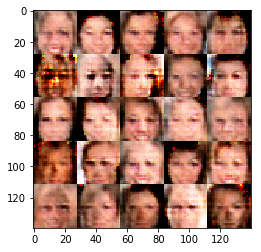

Epoch 1/3... Discriminator Loss: 1.2048... Generator Loss: 1.0547
Epoch 1/3... Discriminator Loss: 1.5216... Generator Loss: 0.4729
Epoch 1/3... Discriminator Loss: 1.3194... Generator Loss: 0.8788
Epoch 1/3... Discriminator Loss: 1.3137... Generator Loss: 1.5193
Epoch 1/3... Discriminator Loss: 1.2297... Generator Loss: 1.7418
Epoch 1/3... Discriminator Loss: 1.3030... Generator Loss: 1.4500
Epoch 1/3... Discriminator Loss: 1.1994... Generator Loss: 1.0845
Epoch 1/3... Discriminator Loss: 1.2487... Generator Loss: 0.8110
Epoch 1/3... Discriminator Loss: 1.2740... Generator Loss: 1.1843
Epoch 1/3... Discriminator Loss: 1.4276... Generator Loss: 0.7656


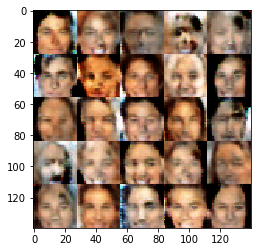

Epoch 1/3... Discriminator Loss: 1.3534... Generator Loss: 0.8942
Epoch 1/3... Discriminator Loss: 1.3643... Generator Loss: 0.8758
Epoch 1/3... Discriminator Loss: 1.2508... Generator Loss: 0.9555
Epoch 1/3... Discriminator Loss: 1.2977... Generator Loss: 0.6321
Epoch 1/3... Discriminator Loss: 1.1534... Generator Loss: 1.1354
Epoch 1/3... Discriminator Loss: 1.2950... Generator Loss: 0.6593
Epoch 1/3... Discriminator Loss: 1.4863... Generator Loss: 1.6085
Epoch 1/3... Discriminator Loss: 1.1859... Generator Loss: 1.0779
Epoch 1/3... Discriminator Loss: 1.3628... Generator Loss: 1.2685
Epoch 1/3... Discriminator Loss: 1.2954... Generator Loss: 0.7118


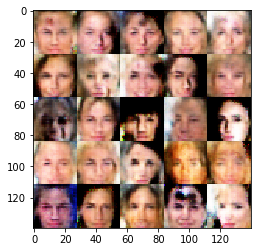

Epoch 1/3... Discriminator Loss: 1.1869... Generator Loss: 1.0397
Epoch 1/3... Discriminator Loss: 1.5902... Generator Loss: 0.4278
Epoch 1/3... Discriminator Loss: 1.2454... Generator Loss: 0.9246
Epoch 1/3... Discriminator Loss: 1.3111... Generator Loss: 0.7617
Epoch 1/3... Discriminator Loss: 1.5237... Generator Loss: 0.5063
Epoch 1/3... Discriminator Loss: 1.4057... Generator Loss: 0.5792
Epoch 1/3... Discriminator Loss: 1.1556... Generator Loss: 0.8456
Epoch 1/3... Discriminator Loss: 1.2334... Generator Loss: 0.7600
Epoch 1/3... Discriminator Loss: 1.2430... Generator Loss: 0.9085
Epoch 1/3... Discriminator Loss: 1.2845... Generator Loss: 0.6520


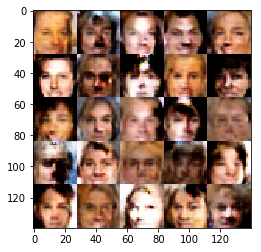

Epoch 1/3... Discriminator Loss: 1.3260... Generator Loss: 1.1266
Epoch 1/3... Discriminator Loss: 1.3588... Generator Loss: 0.5877
Epoch 1/3... Discriminator Loss: 1.4832... Generator Loss: 1.8146
Epoch 1/3... Discriminator Loss: 1.3580... Generator Loss: 0.6248
Epoch 1/3... Discriminator Loss: 1.2852... Generator Loss: 0.7040
Epoch 1/3... Discriminator Loss: 1.4334... Generator Loss: 0.5977
Epoch 1/3... Discriminator Loss: 1.2247... Generator Loss: 1.0584
Epoch 1/3... Discriminator Loss: 1.3597... Generator Loss: 0.8059
Epoch 1/3... Discriminator Loss: 1.3877... Generator Loss: 0.7602
Epoch 2/3... Discriminator Loss: 1.3528... Generator Loss: 1.0269


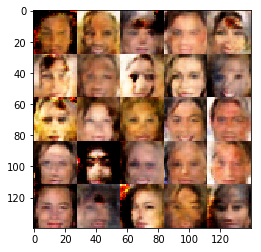

Epoch 2/3... Discriminator Loss: 1.2147... Generator Loss: 1.0834
Epoch 2/3... Discriminator Loss: 1.2674... Generator Loss: 1.2303
Epoch 2/3... Discriminator Loss: 1.2537... Generator Loss: 1.0416
Epoch 2/3... Discriminator Loss: 1.2109... Generator Loss: 0.9503
Epoch 2/3... Discriminator Loss: 1.2781... Generator Loss: 1.1088
Epoch 2/3... Discriminator Loss: 1.3783... Generator Loss: 1.3546
Epoch 2/3... Discriminator Loss: 1.3941... Generator Loss: 1.2354
Epoch 2/3... Discriminator Loss: 1.2866... Generator Loss: 0.6225
Epoch 2/3... Discriminator Loss: 1.2682... Generator Loss: 0.8569
Epoch 2/3... Discriminator Loss: 1.3038... Generator Loss: 0.8575


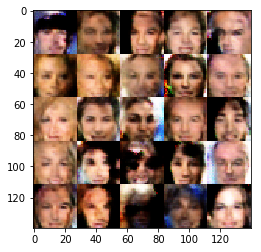

Epoch 2/3... Discriminator Loss: 2.0699... Generator Loss: 2.6665
Epoch 2/3... Discriminator Loss: 1.3176... Generator Loss: 1.1050
Epoch 2/3... Discriminator Loss: 1.3152... Generator Loss: 0.6983
Epoch 2/3... Discriminator Loss: 1.3317... Generator Loss: 0.7321
Epoch 2/3... Discriminator Loss: 1.4385... Generator Loss: 1.0118
Epoch 2/3... Discriminator Loss: 1.3621... Generator Loss: 0.8040
Epoch 2/3... Discriminator Loss: 1.4757... Generator Loss: 0.4564
Epoch 2/3... Discriminator Loss: 1.2150... Generator Loss: 1.0686
Epoch 2/3... Discriminator Loss: 1.3460... Generator Loss: 0.5701
Epoch 2/3... Discriminator Loss: 1.1919... Generator Loss: 1.2356


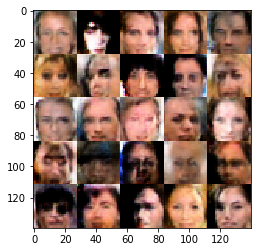

Epoch 2/3... Discriminator Loss: 1.2640... Generator Loss: 0.8028
Epoch 2/3... Discriminator Loss: 1.2664... Generator Loss: 1.0292
Epoch 2/3... Discriminator Loss: 1.2760... Generator Loss: 1.1371
Epoch 2/3... Discriminator Loss: 1.3310... Generator Loss: 1.2243
Epoch 2/3... Discriminator Loss: 1.3337... Generator Loss: 0.6158
Epoch 2/3... Discriminator Loss: 1.3005... Generator Loss: 0.7918
Epoch 2/3... Discriminator Loss: 1.3686... Generator Loss: 1.1833
Epoch 2/3... Discriminator Loss: 1.2837... Generator Loss: 0.9508
Epoch 2/3... Discriminator Loss: 1.1923... Generator Loss: 0.8496
Epoch 2/3... Discriminator Loss: 1.2501... Generator Loss: 0.9903


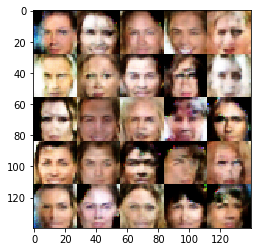

Epoch 2/3... Discriminator Loss: 1.3778... Generator Loss: 0.5670
Epoch 2/3... Discriminator Loss: 1.3628... Generator Loss: 0.6040
Epoch 2/3... Discriminator Loss: 1.2942... Generator Loss: 0.8129
Epoch 2/3... Discriminator Loss: 1.6596... Generator Loss: 0.4098
Epoch 2/3... Discriminator Loss: 1.1752... Generator Loss: 0.9703
Epoch 2/3... Discriminator Loss: 1.4395... Generator Loss: 0.4760
Epoch 2/3... Discriminator Loss: 1.3341... Generator Loss: 0.7898
Epoch 2/3... Discriminator Loss: 1.2217... Generator Loss: 1.1129
Epoch 2/3... Discriminator Loss: 1.2385... Generator Loss: 0.9067
Epoch 2/3... Discriminator Loss: 1.2805... Generator Loss: 0.8507


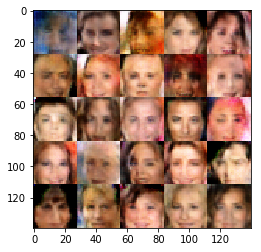

Epoch 2/3... Discriminator Loss: 1.2028... Generator Loss: 1.0924
Epoch 2/3... Discriminator Loss: 1.3417... Generator Loss: 0.7058
Epoch 2/3... Discriminator Loss: 1.2673... Generator Loss: 0.9147
Epoch 2/3... Discriminator Loss: 1.2833... Generator Loss: 0.8107
Epoch 2/3... Discriminator Loss: 1.3973... Generator Loss: 0.6555
Epoch 2/3... Discriminator Loss: 1.2689... Generator Loss: 1.0471
Epoch 2/3... Discriminator Loss: 1.4161... Generator Loss: 1.2326
Epoch 2/3... Discriminator Loss: 1.3106... Generator Loss: 1.1694
Epoch 2/3... Discriminator Loss: 1.2940... Generator Loss: 1.0364
Epoch 2/3... Discriminator Loss: 1.2130... Generator Loss: 0.9397


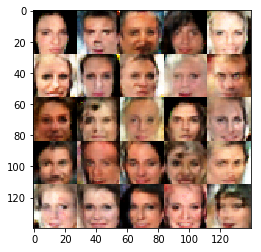

Epoch 2/3... Discriminator Loss: 1.2582... Generator Loss: 0.9130
Epoch 2/3... Discriminator Loss: 1.2333... Generator Loss: 0.9363
Epoch 2/3... Discriminator Loss: 1.3043... Generator Loss: 0.7661
Epoch 2/3... Discriminator Loss: 1.2928... Generator Loss: 1.1395
Epoch 2/3... Discriminator Loss: 1.3108... Generator Loss: 0.8914
Epoch 2/3... Discriminator Loss: 1.2538... Generator Loss: 0.9262
Epoch 2/3... Discriminator Loss: 1.2789... Generator Loss: 0.8471
Epoch 2/3... Discriminator Loss: 1.2664... Generator Loss: 0.8585
Epoch 2/3... Discriminator Loss: 1.1905... Generator Loss: 0.9653
Epoch 2/3... Discriminator Loss: 1.3108... Generator Loss: 0.6900


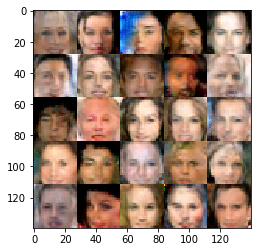

Epoch 2/3... Discriminator Loss: 1.2583... Generator Loss: 0.7731
Epoch 2/3... Discriminator Loss: 1.2522... Generator Loss: 0.9259
Epoch 2/3... Discriminator Loss: 1.2196... Generator Loss: 0.9955
Epoch 2/3... Discriminator Loss: 1.4111... Generator Loss: 1.3888
Epoch 2/3... Discriminator Loss: 1.4551... Generator Loss: 0.5264
Epoch 2/3... Discriminator Loss: 1.2534... Generator Loss: 0.9862
Epoch 2/3... Discriminator Loss: 1.2276... Generator Loss: 0.8912
Epoch 2/3... Discriminator Loss: 1.2188... Generator Loss: 1.0926
Epoch 2/3... Discriminator Loss: 1.2351... Generator Loss: 0.9825
Epoch 2/3... Discriminator Loss: 1.3352... Generator Loss: 0.8686


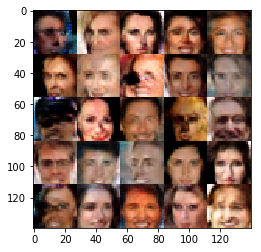

Epoch 2/3... Discriminator Loss: 1.5220... Generator Loss: 1.3909
Epoch 2/3... Discriminator Loss: 1.3302... Generator Loss: 1.3363
Epoch 2/3... Discriminator Loss: 1.3517... Generator Loss: 0.8102
Epoch 2/3... Discriminator Loss: 1.3174... Generator Loss: 0.8768
Epoch 2/3... Discriminator Loss: 1.3281... Generator Loss: 0.8421
Epoch 2/3... Discriminator Loss: 1.3377... Generator Loss: 0.6757
Epoch 2/3... Discriminator Loss: 1.3124... Generator Loss: 0.9270
Epoch 2/3... Discriminator Loss: 1.3069... Generator Loss: 0.7038
Epoch 2/3... Discriminator Loss: 1.4101... Generator Loss: 1.1735
Epoch 2/3... Discriminator Loss: 1.3398... Generator Loss: 0.6301


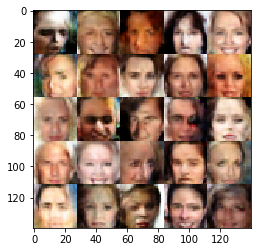

Epoch 2/3... Discriminator Loss: 1.3303... Generator Loss: 0.7201
Epoch 2/3... Discriminator Loss: 1.3361... Generator Loss: 0.9890
Epoch 2/3... Discriminator Loss: 1.2618... Generator Loss: 0.8515
Epoch 2/3... Discriminator Loss: 1.4493... Generator Loss: 1.2640
Epoch 2/3... Discriminator Loss: 1.3178... Generator Loss: 1.2285
Epoch 2/3... Discriminator Loss: 1.2963... Generator Loss: 0.7111
Epoch 2/3... Discriminator Loss: 1.3166... Generator Loss: 1.0310
Epoch 2/3... Discriminator Loss: 1.3345... Generator Loss: 0.7095
Epoch 2/3... Discriminator Loss: 1.2749... Generator Loss: 1.0559
Epoch 2/3... Discriminator Loss: 1.2404... Generator Loss: 0.9788


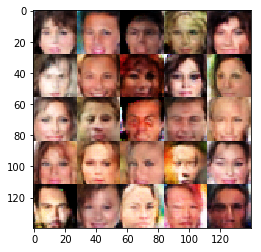

Epoch 2/3... Discriminator Loss: 1.2381... Generator Loss: 0.9969
Epoch 2/3... Discriminator Loss: 1.2332... Generator Loss: 0.9665
Epoch 2/3... Discriminator Loss: 1.3532... Generator Loss: 0.9016
Epoch 2/3... Discriminator Loss: 1.3186... Generator Loss: 0.8350
Epoch 2/3... Discriminator Loss: 1.2721... Generator Loss: 0.9315
Epoch 2/3... Discriminator Loss: 1.2742... Generator Loss: 1.2330
Epoch 2/3... Discriminator Loss: 1.2436... Generator Loss: 0.7685
Epoch 2/3... Discriminator Loss: 1.2478... Generator Loss: 0.9385
Epoch 2/3... Discriminator Loss: 1.3506... Generator Loss: 1.1736
Epoch 3/3... Discriminator Loss: 1.2429... Generator Loss: 0.8344


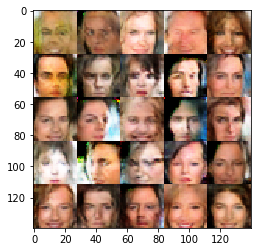

Epoch 3/3... Discriminator Loss: 1.2713... Generator Loss: 0.8903
Epoch 3/3... Discriminator Loss: 1.3097... Generator Loss: 1.2587
Epoch 3/3... Discriminator Loss: 1.3102... Generator Loss: 1.0462
Epoch 3/3... Discriminator Loss: 1.3963... Generator Loss: 1.3489
Epoch 3/3... Discriminator Loss: 1.3694... Generator Loss: 0.7273
Epoch 3/3... Discriminator Loss: 1.2828... Generator Loss: 0.7343
Epoch 3/3... Discriminator Loss: 1.3342... Generator Loss: 0.7496
Epoch 3/3... Discriminator Loss: 1.2495... Generator Loss: 0.8971
Epoch 3/3... Discriminator Loss: 1.2936... Generator Loss: 0.9218
Epoch 3/3... Discriminator Loss: 1.2479... Generator Loss: 0.9754


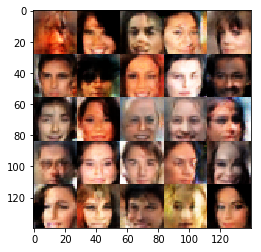

Epoch 3/3... Discriminator Loss: 1.2303... Generator Loss: 0.7394
Epoch 3/3... Discriminator Loss: 1.3996... Generator Loss: 1.2536
Epoch 3/3... Discriminator Loss: 1.3669... Generator Loss: 1.1604
Epoch 3/3... Discriminator Loss: 1.1524... Generator Loss: 0.9588
Epoch 3/3... Discriminator Loss: 1.2329... Generator Loss: 0.8990
Epoch 3/3... Discriminator Loss: 1.2897... Generator Loss: 0.9325
Epoch 3/3... Discriminator Loss: 1.3147... Generator Loss: 0.8988
Epoch 3/3... Discriminator Loss: 1.2906... Generator Loss: 0.8487
Epoch 3/3... Discriminator Loss: 1.2254... Generator Loss: 0.9085
Epoch 3/3... Discriminator Loss: 1.2733... Generator Loss: 0.7804


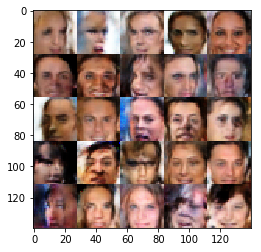

Epoch 3/3... Discriminator Loss: 1.2672... Generator Loss: 0.8848
Epoch 3/3... Discriminator Loss: 1.2528... Generator Loss: 0.8321
Epoch 3/3... Discriminator Loss: 1.1881... Generator Loss: 0.9845
Epoch 3/3... Discriminator Loss: 1.3988... Generator Loss: 0.6617
Epoch 3/3... Discriminator Loss: 1.2822... Generator Loss: 0.8021
Epoch 3/3... Discriminator Loss: 1.2269... Generator Loss: 1.0659
Epoch 3/3... Discriminator Loss: 1.2415... Generator Loss: 1.0070
Epoch 3/3... Discriminator Loss: 1.2559... Generator Loss: 1.0794
Epoch 3/3... Discriminator Loss: 1.3603... Generator Loss: 0.5901
Epoch 3/3... Discriminator Loss: 1.3017... Generator Loss: 0.7474


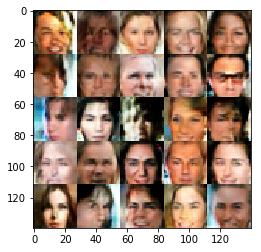

Epoch 3/3... Discriminator Loss: 1.3133... Generator Loss: 0.9720
Epoch 3/3... Discriminator Loss: 1.2373... Generator Loss: 1.1475
Epoch 3/3... Discriminator Loss: 1.2905... Generator Loss: 0.7846
Epoch 3/3... Discriminator Loss: 1.3015... Generator Loss: 0.6865
Epoch 3/3... Discriminator Loss: 1.3144... Generator Loss: 1.2666
Epoch 3/3... Discriminator Loss: 1.3981... Generator Loss: 0.5863
Epoch 3/3... Discriminator Loss: 1.2788... Generator Loss: 0.7808
Epoch 3/3... Discriminator Loss: 1.2652... Generator Loss: 1.3483
Epoch 3/3... Discriminator Loss: 1.2728... Generator Loss: 1.2593
Epoch 3/3... Discriminator Loss: 1.2652... Generator Loss: 1.0888


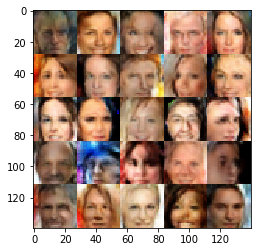

Epoch 3/3... Discriminator Loss: 1.2908... Generator Loss: 0.8452
Epoch 3/3... Discriminator Loss: 1.2484... Generator Loss: 0.8793
Epoch 3/3... Discriminator Loss: 1.2320... Generator Loss: 1.1709
Epoch 3/3... Discriminator Loss: 1.2889... Generator Loss: 1.0577
Epoch 3/3... Discriminator Loss: 1.2573... Generator Loss: 0.7711
Epoch 3/3... Discriminator Loss: 1.4094... Generator Loss: 0.5677
Epoch 3/3... Discriminator Loss: 1.2666... Generator Loss: 0.7531
Epoch 3/3... Discriminator Loss: 1.2386... Generator Loss: 1.2502
Epoch 3/3... Discriminator Loss: 1.2813... Generator Loss: 0.7924
Epoch 3/3... Discriminator Loss: 1.3410... Generator Loss: 0.6252


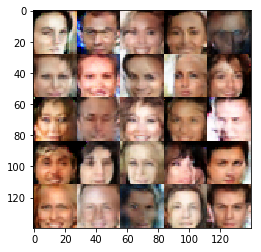

Epoch 3/3... Discriminator Loss: 1.2508... Generator Loss: 0.9877
Epoch 3/3... Discriminator Loss: 1.3268... Generator Loss: 1.2523
Epoch 3/3... Discriminator Loss: 1.2823... Generator Loss: 0.7789
Epoch 3/3... Discriminator Loss: 1.2252... Generator Loss: 0.9101
Epoch 3/3... Discriminator Loss: 1.4438... Generator Loss: 1.5660
Epoch 3/3... Discriminator Loss: 1.2021... Generator Loss: 1.1771
Epoch 3/3... Discriminator Loss: 1.2400... Generator Loss: 0.9156
Epoch 3/3... Discriminator Loss: 1.2428... Generator Loss: 1.0660
Epoch 3/3... Discriminator Loss: 1.2365... Generator Loss: 1.1802
Epoch 3/3... Discriminator Loss: 1.3241... Generator Loss: 0.6553


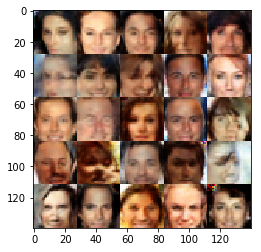

Epoch 3/3... Discriminator Loss: 1.2715... Generator Loss: 1.1780
Epoch 3/3... Discriminator Loss: 1.2025... Generator Loss: 0.8897
Epoch 3/3... Discriminator Loss: 1.3619... Generator Loss: 1.0811
Epoch 3/3... Discriminator Loss: 1.2595... Generator Loss: 1.0964
Epoch 3/3... Discriminator Loss: 1.2405... Generator Loss: 0.8016
Epoch 3/3... Discriminator Loss: 1.3311... Generator Loss: 0.6927
Epoch 3/3... Discriminator Loss: 1.3911... Generator Loss: 0.6152
Epoch 3/3... Discriminator Loss: 1.2808... Generator Loss: 0.8158
Epoch 3/3... Discriminator Loss: 1.2239... Generator Loss: 1.0949
Epoch 3/3... Discriminator Loss: 1.2576... Generator Loss: 1.3419


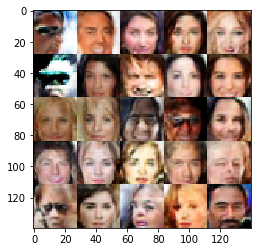

Epoch 3/3... Discriminator Loss: 1.2991... Generator Loss: 0.7382
Epoch 3/3... Discriminator Loss: 1.3622... Generator Loss: 0.5888
Epoch 3/3... Discriminator Loss: 1.3267... Generator Loss: 0.8055
Epoch 3/3... Discriminator Loss: 1.2525... Generator Loss: 0.9066
Epoch 3/3... Discriminator Loss: 1.4030... Generator Loss: 1.5158
Epoch 3/3... Discriminator Loss: 1.2081... Generator Loss: 0.9757
Epoch 3/3... Discriminator Loss: 1.1636... Generator Loss: 1.0183
Epoch 3/3... Discriminator Loss: 1.2866... Generator Loss: 1.1605
Epoch 3/3... Discriminator Loss: 1.2479... Generator Loss: 0.8921
Epoch 3/3... Discriminator Loss: 1.2445... Generator Loss: 0.7672


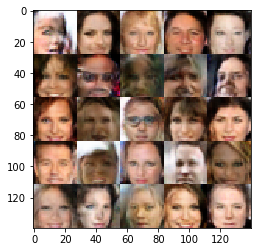

Epoch 3/3... Discriminator Loss: 1.2942... Generator Loss: 0.9145
Epoch 3/3... Discriminator Loss: 1.2956... Generator Loss: 0.6229
Epoch 3/3... Discriminator Loss: 1.2045... Generator Loss: 0.9290
Epoch 3/3... Discriminator Loss: 1.3023... Generator Loss: 0.7110
Epoch 3/3... Discriminator Loss: 1.2777... Generator Loss: 1.1565
Epoch 3/3... Discriminator Loss: 1.2976... Generator Loss: 0.6931
Epoch 3/3... Discriminator Loss: 1.2213... Generator Loss: 0.9026
Epoch 3/3... Discriminator Loss: 1.2795... Generator Loss: 0.8309
Epoch 3/3... Discriminator Loss: 1.2661... Generator Loss: 0.7403
Epoch 3/3... Discriminator Loss: 1.2182... Generator Loss: 0.8275


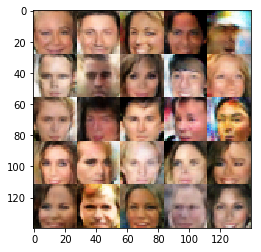

Epoch 3/3... Discriminator Loss: 1.2443... Generator Loss: 0.7175
Epoch 3/3... Discriminator Loss: 1.2417... Generator Loss: 1.0418
Epoch 3/3... Discriminator Loss: 1.2845... Generator Loss: 0.8325
Epoch 3/3... Discriminator Loss: 1.3272... Generator Loss: 0.8026
Epoch 3/3... Discriminator Loss: 1.2800... Generator Loss: 0.9909
Epoch 3/3... Discriminator Loss: 1.1546... Generator Loss: 0.8664
Epoch 3/3... Discriminator Loss: 1.2819... Generator Loss: 1.3950
Epoch 3/3... Discriminator Loss: 1.2113... Generator Loss: 0.8284


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 3

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.